In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import multiprocessing
from scipy.spatial.distance import cdist
import yaml
from datetime import datetime

import warnings
warnings.simplefilter('ignore')

import math
import numpy as np
from cv2 import Rodrigues
from math import sin, cos, atan2, sqrt
import pandas as pd
from pathlib import Path
import pyproj
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
def init_logger(log_file='logger.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
    
today = datetime.now().strftime('%Y-%m-%d')
logger = init_logger(log_file=f'./{today}.log')
logger.info('Start Logging...')

Start Logging...


In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [5]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# waypointを補正したdataset
root_dir = Path('../../input')
data_dir = root_dir/'google-smartphone-decimeter-challenge'
collection_type_dict = from_pickle(root_dir/"road_type.pkl") # by edge'sdegree and highway feature
collection_type_dict["test"]['2021-03-25-US-PAO-1'] = "normal"

In [6]:
collection_type_dict

{'train': {'2020-05-14-US-MTV-1': 'highway',
  '2020-05-14-US-MTV-2': 'highway',
  '2020-05-21-US-MTV-1': 'highway',
  '2020-05-21-US-MTV-2': 'highway',
  '2020-05-29-US-MTV-1': 'highway',
  '2020-05-29-US-MTV-2': 'highway',
  '2020-06-04-US-MTV-1': 'highway',
  '2020-06-05-US-MTV-1': 'highway',
  '2020-06-05-US-MTV-2': 'highway',
  '2020-06-11-US-MTV-1': 'highway',
  '2020-07-08-US-MTV-1': 'highway',
  '2020-07-17-US-MTV-1': 'highway',
  '2020-07-17-US-MTV-2': 'highway',
  '2020-08-03-US-MTV-1': 'highway',
  '2020-08-06-US-MTV-2': 'highway',
  '2020-09-04-US-SF-1': 'highway',
  '2020-09-04-US-SF-2': 'highway',
  '2021-01-04-US-RWC-1': 'highway',
  '2021-01-04-US-RWC-2': 'highway',
  '2021-01-05-US-SVL-1': 'highway',
  '2021-01-05-US-SVL-2': 'highway',
  '2021-03-10-US-SVL-1': 'normal',
  '2021-04-15-US-MTV-1': 'normal',
  '2021-04-22-US-SJC-1': 'city',
  '2021-04-26-US-SVL-1': 'normal',
  '2021-04-28-US-MTV-1': 'normal',
  '2021-04-28-US-SJC-1': 'city',
  '2021-04-29-US-MTV-1': 'norma

In [7]:
def get_ground_truth(args):
    (collectionName, phoneName), df = args
    
    path = data_dir / f"train/{collectionName}/{phoneName}/ground_truth.csv"
    target_df = pd.read_csv(path)
    output_df = pd.DataFrame()
    # merge derived and target by 'millisSinceGpsEpoch'
    for epoch, epoch_df in df.groupby('millisSinceGpsEpoch'):
        idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
        epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
        epoch_df['epoch_diff'] = epoch_diff
        epoch_df['target_latDeg'] = target_df.loc[idx, 'latDeg']
        epoch_df['target_lngDeg'] = target_df.loc[idx, 'lngDeg']
        epoch_df['speedMps'] = target_df.loc[idx, 'speedMps']
        output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

In [8]:
import plotly.express as px

def visualize_trafic(df):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            text='phoneName',
                            
                            #Here, plotly detects color of series
                            color="collectionName",
                            labels="collectionName",
                            
                            zoom=9,
                            center={"lat":37.423576, "lon":-122.094132},
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()


def visualize_collection(df, hover_data=["elapsed_epoch", "speedMps"], collection_name='2021-04-29-US-SJC-2'):
    gt_df = pd.read_csv(root_dir / 'all_ground_truth.csv')
    gt_df['phoneName'] = 'ground truth'
    gt_df = pd.concat([df, gt_df])
    target_df = gt_df[gt_df['collectionName']==collection_name]   
    target_df['elapsed_epoch'] = ((target_df['millisSinceGpsEpoch'] - target_df['millisSinceGpsEpoch'].min()) / 1000)
    fig = px.scatter_mapbox(target_df,
                                
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                                
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            hover_data=hover_data,                

                                
                            zoom=9,
                            center={"lat":37.423576, "lon":-122.094132},
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="{collection_name}")
    fig.show()

In [9]:
# metric
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    if "phone" not in input_df.columns:
        input_df["phone"] = input_df["collectionName"] + "_" + input_df["phoneName"]

    if "target_latDeg" not in input_df.columns:
        processes = multiprocessing.cpu_count()
        with multiprocessing.Pool(processes=processes) as pool:
            gr = input_df.groupby(['collectionName','phoneName'])
            dfs = pool.imap_unordered(get_ground_truth, gr)
            dfs = tqdm(dfs, total=len(gr))
            dfs = list(dfs)
        input_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch']).reset_index(drop=True)     


    output_df = input_df.copy()
    
    output_df['error'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.target_latDeg, r.target_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['error'].mean()
    logger.info(f'mean error: {meter_score}')

    scores = []
    p_50_scores = []
    p_95_scores = []
    mean_scores = []
    phones = []
    score_df = pd.DataFrame()
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'error'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'error'], 95)
        # print(f"{phone} | 50:{p_50:.5g}| 95:{p_95:.5g}")
        p_50_scores.append(p_50)
        p_95_scores.append(p_95)
        mean_scores.append(np.mean([p_50, p_95]))
        phones.append(phone)

        scores.append(p_50)
        scores.append(p_95)

    score_df["phone"] = phones
    score_df["p_50_score"] = p_50_scores
    score_df["p_95_score"] = p_95_scores
    score_df["mean_score"] = mean_scores
    
    comp_score = sum(scores) / len(scores)
    logger.info(f"competition metric:{comp_score}")
    return output_df, score_df

In [10]:
import simdkalman

def apply_kf_smoothing(input_df, phase="train"):
    logger.info('[START] Kalman Smoothing')
    # define kf model
    df_list = []
    for (collection_name,phone_name), df in input_df.groupby(["collectionName", "phoneName"]):
        df = df.sort_values("millisSinceGpsEpoch")
        if collection_type_dict[phase][collection_name] == "highway":
            # score: 2.8204355271575277 -> 2.8193315973589166
            # Best hyperparameters: {'T': 2.0, 'p_noise': 2.705460166533897e-07, 'o_noise': 1.3966292122575907e-09}
            # defaultを使用
            T = 1.0
            p_noise = 1e-9
            o_noise = 1e-9

            state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                                        [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
            process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * p_noise
            observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])    
            observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * o_noise

        elif collection_type_dict[phase][collection_name] == "normal":
            # score: 5.278659054251117 -> 5.213777593582035
            # Best hyperparameters: {'T': 0.9, 'p_noise': 1.0380420148601327e-12, 'o_noise': 6.122291790973238e-06}
            T = 0.9
            p_noise = 1e-12
            o_noise = 6.1e-6

            state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                                        [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
            process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * p_noise
            observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])    
            observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * o_noise
        else:
            # score: 18.002721439031802 -> 17.71027356807068
            # Best hyperparameters: {'T': 0.30000000000000004, 'p_noise': 1.4040850185364873e-12, 'o_noise': 1.2221845582747804e-08}  
            T = 0.3
            p_noise = 1.4e-12
            o_noise = 1.2e-8

            state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                                        [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
            process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * p_noise
            observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])    
            observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * o_noise

        kf = simdkalman.KalmanFilter(
            state_transition=state_transition,
            process_noise=process_noise,
            observation_model=observation_model,
            observation_noise=observation_noise)

        data = df[['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf.smooth(data)
        df['latDeg'] = smoothed.states.mean[0, :, 0]
        df['lngDeg'] = smoothed.states.mean[0, :, 1]
        df_list.append(df)
    output_df = pd.concat(df_list).reset_index(drop=True) # .sort_index()
    return output_df

In [11]:
# https://www.kaggle.com/dehokanta/baseline-post-processing-by-outlier-correction
def outlier_correction(df):
    logger.info('[START] outlier correction')
    df['dist_pre'] = 0
    df['dist_pro'] = 0
    df['latDeg_pre'] = df['latDeg'].shift(periods=1,fill_value=0)
    df['lngDeg_pre'] = df['lngDeg'].shift(periods=1,fill_value=0)
    df['latDeg_pro'] = df['latDeg'].shift(periods=-1,fill_value=0)
    df['lngDeg_pro'] = df['lngDeg'].shift(periods=-1,fill_value=0)
    df['dist_pre'] = calc_haversine(df["latDeg_pre"], df["lngDeg_pre"], df["latDeg"], df["lngDeg"])
    df['dist_pro'] = calc_haversine(df["latDeg"], df["lngDeg"], df["latDeg_pro"], df["lngDeg_pro"])

    list_phone = df['phone'].unique()
    for phone in list_phone:
        ind_s = df[df['phone'] == phone].index[0]
        ind_e = df[df['phone'] == phone].index[-1]
        df.loc[ind_s,'dist_pre'] = 0
        df.loc[ind_e,'dist_pro'] = 0

    pro_95 = df['dist_pro'].mean() + (df['dist_pro'].std() * 2)
    pre_95 = df['dist_pre'].mean() + (df['dist_pre'].std() * 2)
    ind = df[(df['dist_pro'] > pro_95)&(df['dist_pre'] > pre_95)][['dist_pre','dist_pro']].index

    for i in ind:
        df.loc[i,'latDeg'] = (df.loc[i-1,'latDeg'] + df.loc[i+1,'latDeg'])/2
        df.loc[i,'lngDeg'] = (df.loc[i-1,'lngDeg'] + df.loc[i+1,'lngDeg'])/2
    return df


def linear_interpolation(input_df, speed_thr=45):
    logger.info('[START] linear interpolation')
    dfs = pd.DataFrame()
    use_col = input_df.columns
    for (collectionName, phoneName), df in input_df.groupby(['collectionName', 'phoneName']):

        df['delta'] = calc_haversine(
            df['latDeg'], df['lngDeg'], df['latDeg'].shift(1), df['lngDeg'].shift(1))
        df['time_delta'] = df['millisSinceGpsEpoch'] - \
            df['millisSinceGpsEpoch'].shift(1)
        df['delta'].fillna(0, inplace=True)
        df['time_delta'].fillna(0, inplace=True)
        df['speed'] = df['delta'] / (df['time_delta']/1000)  # m/s
        df['speed'].fillna(0, inplace=True)

        # 一度欠損値にする
        df.loc[speed_thr < df['speed'], ['latDeg', 'lngDeg']] = np.nan
        df['dummy_datetime'] = pd.to_datetime(df['millisSinceGpsEpoch'])
        df = df.set_index('dummy_datetime')

        # 時間に合わせて線形補間
        df = df.interpolate(method='time').reset_index(drop=True)
        dfs = pd.concat([dfs, df]).reset_index(drop=True)
    return dfs[use_col]

In [12]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns

    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list = df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')

    lerp_df = tmp.merge(
        df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')

    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])

    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)

    # Leave only records to be interpolated(missing coords data)
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull()) & (lerp_df['phone'] == lerp_df['phone_prev']) & (
        lerp_df['phone'] == lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * (
        (lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev'])))
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * (
        (lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev'])))

    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]

    return lerp_df[org_columns]

def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[
        ['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df.copy()
    mean_pred_df = mean_pred_df.drop(["latDeg", "lngDeg"], axis=1)
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=[
                                      'collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

def apply_mean(df):
    logger.info('[START] phone-mean')
    lerp = make_lerp_data(df)
    mean_df = calc_mean_pred(df, lerp)
    return mean_df

In [13]:
def get_removedevice(input_df: pd.DataFrame, device: str) -> pd.DataFrame:
    logger.info('[START] remove device')
    input_df['index'] = input_df.index
    input_df = input_df.sort_values('millisSinceGpsEpoch')
    input_df.index = input_df['millisSinceGpsEpoch'].values

    output_df = pd.DataFrame()
    for _, subdf in input_df.groupby('collectionName'):

        phones = subdf['phoneName'].unique()

        if (len(phones) == 1) or (not device in phones):
            output_df = pd.concat([output_df, subdf])
            continue

        origin_df = subdf.copy()

        _index = subdf['phoneName'] == device
        subdf.loc[_index, 'latDeg'] = np.nan
        subdf.loc[_index, 'lngDeg'] = np.nan
        subdf = subdf.interpolate(method='index', limit_area='inside')

        _index = subdf['latDeg'].isnull()
        subdf.loc[_index, 'latDeg'] = origin_df.loc[_index, 'latDeg'].values
        subdf.loc[_index, 'lngDeg'] = origin_df.loc[_index, 'lngDeg'].values

        output_df = pd.concat([output_df, subdf])

    output_df.index = output_df['index'].values
    output_df = output_df.sort_index()

    del output_df['index']

    return output_df

In [14]:
def stop_mean(input_df, max_speed_thr = 0.95, min_second_thr=0, max_second_thr = 2, phase="train"):
    """
    # 予測した速度がmax_speed_thr以下のものがmax_second_thr(s)以上連続する区間を停止区間とみなして平均をとる。
    TODO 道路タイプで適用可否決めたほうがいいかも。都市のところは開始、終了だけにするとか。
    """
    logger.info('[START] stop mean')
    use_col = input_df.columns
    output_df = pd.DataFrame()
    for collection_name, df in input_df.groupby(['collectionName']):

        df = df.sort_values('millisSinceGpsEpoch')
        df['flag'] = df['pred_speedMps'] < max_speed_thr
        df['stop_group'] = (df['flag'] != df['flag'].shift()).cumsum()
        df['num_flaged_data'] = df.groupby('stop_group')['flag'].transform(sum)  # stop group内でのflag(stopしていると判定された)の数
        df.loc[(min_second_thr <= df['num_flaged_data'])&(df['num_flaged_data'] < max_second_thr), 'stop_group'] = 0

        for i in df['stop_group'].unique():
            if i == 0:
                continue

            if collection_type_dict[phase][collection_name]=='city':
                # when start or end
                if (i == 1)or(i == df['stop_group'].unique()[-1]):
                    df.loc[df['stop_group']==i, 'latDeg'] = df.loc[df['stop_group']==i, 'latDeg'].mean()
                    df.loc[df['stop_group']==i, 'lngDeg'] = df.loc[df['stop_group']==i, 'lngDeg'].mean()
            else:
                df.loc[df['stop_group']==i, 'latDeg'] = df.loc[df['stop_group']==i, 'latDeg'].mean()
                df.loc[df['stop_group']==i, 'lngDeg'] = df.loc[df['stop_group']==i, 'lngDeg'].mean()
        
        output_df = pd.concat([output_df, df])
    return output_df[use_col].sort_index()

In [15]:
train_points = pd.read_csv('../../input/all_ground_truth.csv')
test_points = pd.read_csv('../../input/road_points.csv')
# road_points["place"] = road_points["collectionName"].str[11:]
road_points = pd.concat([train_points, test_points])
road_points = road_points[["lngDeg", "latDeg"]]
road_points

,lngDeg,latDeg
0,-122.080466,37.416314
1,-122.080466,37.416314
2,-122.080466,37.416314
3,-122.080466,37.416314
4,-122.080466,37.416314
...,...,...
12795,-122.157943,37.449564
12796,-122.158041,37.449466
12797,-122.158688,37.448881
12798,-122.159135,37.448374


In [16]:
# fig = px.scatter_mapbox(road_points,                              
#                         # Here, plotly gets, (x,y) coordinates
#                         lat="latDeg",
#                         lon="lngDeg",
                            
#                         zoom=9,
#                         center={"lat":37.423576, "lon":-122.094132},
#                         height=600,
#                         width=800)
# fig.update_layout(mapbox_style='stamen-terrain')
# fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# # fig.update_layout(title_text="{collection_name}")
# fig.show()

In [17]:
def epoch_mean(input_df):
    logger.info('[START] epoch mean')
    output_df = input_df.copy()
    output_df['sSinceGpsEpoch'] = np.round(output_df['millisSinceGpsEpoch'] / 1000, 1)
    print(output_df['millisSinceGpsEpoch'].nunique(), output_df['sSinceGpsEpoch'].nunique())
    output_df = pd.merge(output_df, output_df.groupby('sSinceGpsEpoch')['latDeg', 'lngDeg'].mean().reset_index().rename(columns={'latDeg':'_latDeg', 'lngDeg':'_lngDeg'}), on='sSinceGpsEpoch', how='left')
    output_df = output_df.drop(['latDeg','lngDeg'], axis=1).rename(columns={'_latDeg':'latDeg', '_lngDeg':'lngDeg'})
    # assert df.columns == use_col
    return output_df

In [18]:

def make_road_data(input_df, phase):
    # make road dataframe
    processes = multiprocessing.cpu_count()
    gr = input_df.groupby("collectionName")
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(extract_road_data, gr)
        dfs = tqdm(dfs, total=len(gr))
        dfs = list(dfs)
    road_df = pd.concat(dfs)

    road_type_dict = {
    'unclassified': "1_residential",
    'residential': "1_residential",
    'tertiary_link': "2_tertaiary", 
    'tertiary': "2_tertaiary", 
    'secondary_link': '3_secondary', 
    'secondary': '3_secondary', 
    'primary_link': '4_primary', 
    'primary': '4_primary', 
    'trunk_link': '5_trunk',
    'trunk': '5_trunk',
    'motorway_link': '6_motorway',
    'motorway': '6_motorway',
    }

    road_df["highway"] = [i[0] if type(i)==list else i for i in road_df["highway"]]
    road_df["road_type"] = road_df["highway"].replace(road_type_dict)
    road_df["geometry"] = road_df["geometry"].buffer(0.0001)  # linestring -> polygon
    return road_df

In [19]:
def judge_road_type(x, target_road_df):
    p = x["geometry"]
    for idx, row in target_road_df.iterrows():
        if row["geometry"].contains(p):
            return row["road_type"]
    
def apply_road_type(args):
    (collection_name, df), road_df = args
    target_road_df = road_df[road_df["collectionName"]==collection_name]
    df["road_type"] = df.apply(judge_road_type, target_road_df=target_road_df, axis=1)
    return df


def add_road_type(input_df, phase="train"):
    output_df = input_df.copy()
    use_col = list(input_df.columns)

    road_df = make_road_data(input_df, phase)
    output_df["geometry"] = [Point(lng, lat) for lng, lat in output_df[["lngDeg", "latDeg"]].to_numpy()]
    output_df = gpd.GeoDataFrame(output_df, geometry="geometry")

    processes = multiprocessing.cpu_count()
    n = output_df["collectionName"].nunique()
    gr = zip(output_df.groupby("collectionName"), [road_df]*n)
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(apply_road_type, gr)
        dfs = tqdm(dfs, total=n)
        dfs = list(dfs)
    output_df = pd.concat(dfs)
    output_df["road_type"].fillna("0_unknown", inplace=True)
    return output_df[use_col + ["road_type"]]

In [20]:
from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd
from shapely.ops import nearest_points
import momepy

def extract_road_data(args):
    collection_name, points = args
    ################
    # read load data
    ################
    points["geometry"] = [Point(p) for p in points[["lngDeg", "latDeg"]].to_numpy()]
    points = gpd.GeoDataFrame(points, geometry=points["geometry"])
    offset = 0.1**3
    bbox = points.bounds + [-offset, -offset, offset, offset]
    east = bbox["minx"].min()
    west = bbox["maxx"].max()
    south = bbox["miny"].min()
    north = bbox["maxy"].max()
    G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')
    _, lines = momepy.nx_to_gdf(G)
    lines = lines.dropna(subset=["geometry"]).reset_index(drop=True)
    hits = bbox.apply(lambda row: list(lines.sindex.intersection(row)), axis=1)
    tmp = pd.DataFrame({
        # index of points table
        "pt_idx": np.repeat(hits.index, hits.apply(len)),
        # ordinal position of line - access via iloc later
        "line_i": np.concatenate(hits.values)
    })
    # Join back to the lines on line_i; we use reset_index() to 
    # give us the ordinal position of each line
    tmp = tmp.join(lines.reset_index(drop=True), on="line_i")
    # Join back to the original points to get their geometry
    # rename the point geometry as "point"
    tmp = tmp.join(points.geometry.rename("point"), on="pt_idx")
    # Convert back to a GeoDataFrame, so we can do spatial ops
    tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=points.crs)

    ####################
    # Find closest line
    ###################
    tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

    # Discard any lines that are greater than tolerance from points
    tolerance = 0.0001 # 0.0005
    tmp = tmp.loc[tmp.snap_dist <= tolerance]
    # Sort on ascending snap distance, so that closest goes to top
    tmp = tmp.sort_values(by=["snap_dist"])

    # group by the index of the points and take the first, which is the
    # closest line 
    closest = tmp.groupby("pt_idx").first()
    # construct a GeoDataFrame of the closest lines
    # closest = gpd.GeoDataFrame(closest, geometry="geometry")
    closest = closest.drop_duplicates("line_i").reset_index(drop=True)

    closest.drop(['point','snap_dist'], axis=1, inplace=True)
    closest['collectionName'] = collection_name
    return closest



In [21]:
def snap_to_grid(df, min_thr, max_thr):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    df['_latDeg_'] = df['latDeg']
    df['_lngDeg_'] = df['lngDeg']
    df["dist"] = calc_haversine(df["latDeg"], df["lngDeg"], df["latDeg_"], df["lngDeg_"])
    query = (min_thr <= df['dist'])&(df['dist'] < max_thr)
    df.loc[query, '_latDeg_'] = df.loc[query, 'latDeg_']
    df.loc[query, '_lngDeg_'] = df.loc[query, 'lngDeg_']

    df = df.drop(["latDeg_", "lngDeg_", "latDeg", "lngDeg"], axis=1).rename(columns={"_latDeg_":"latDeg", "_lngDeg_":"lngDeg"})
    return df

from scipy.spatial.distance import cdist

def add_xy(df):
    df['point'] = [(x, y) for x,y in zip(df['lngDeg'], df['latDeg'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]


def matching_point(target_df, target_road_points=road_points):
    # place = target_df["place"].unique()[0]
    # target_road_points = road_points[road_points["place"]==place]
    target_df['matched_point'] = [closest_point(x, list(target_road_points['point'])) for x in target_df['point']]
    target_df['lngDeg_'] = target_df['matched_point'].apply(lambda x: x[0])
    target_df['latDeg_'] = target_df['matched_point'].apply(lambda x: x[1])
    return target_df


def apply_snap_to_grid(df, road_points, min_thr, max_thr, phase="train"):
    logger.info('[START] Snap to Grid')

    df = add_xy(df)
    road_points = add_xy(road_points)
    df_list = []
    ncpu = multiprocessing.cpu_count()
    for collection_name, coll_df in tqdm(df.groupby("collectionName")):
        for road_type, target_df in coll_df.groupby("road_type"):
            query1 = collection_type_dict[phase][collection_name] == "city"  # 3.7096
            # query2 = (road_type_dict[collection_name] == "highway")&(road_type == "3_secondary")  # 3.9642
            # query3 = (road_type_dict[collection_name] == "city")&(road_type == "0_unknown")  # 3.7523
            # query4 = (road_type_dict[collection_name] == "city")&(road_type in ["0_unknown", "1_residential"])  # 3.7206
            # query5 = (collection_type_dict[phase][collection_name] == "normal")&(road_type in ["0_unknown"])  # 3.9419
            # query6 = (road_type_dict[collection_name] == "normal")&(road_type == "3_secondary")  # 4.0647
            # query7 = road_type == "5_trunk"  # 3.952
            # query8 = (road_type_dict[collection_name] == "highway")&(road_type in ["0_unknown"])  # 4.2378
            if (query1):

                # collectionの主要な道路種がcityならsnap to grid
                target_df = target_df.reset_index(drop=True)

                k = round(len(target_df)/ncpu)
                if k == 0:
                    k = 1
                target_dfs = [target_df.loc[i:i+k-1, :] for i in range(0, len(target_df), k)]
                with multiprocessing.Pool(processes=ncpu) as pool:
                    dfs = pool.imap_unordered(matching_point, target_dfs)
                    dfs = list(tqdm(dfs, total=len(target_dfs)))
                    target_df = pd.concat(dfs)
                target_df = snap_to_grid(target_df, min_thr, max_thr)
                df_list.append(target_df)
            else:
                df_list.append(target_df)

    df = pd.concat(df_list).reset_index(drop=True)
    
    return df

In [22]:
def sort_epoch(input_df):
    df_list = []
    for (collectionName, phoneName), df in input_df.groupby(["collectionName", "phoneName"]):
        df = df.sort_values("millisSinceGpsEpoch")
        df_list.append(df)
    output_df = pd.concat(df_list).reset_index(drop=True)
    return output_df

In [23]:

sub_df = pd.read_csv(data_dir / 'sample_submission.csv')

In [25]:

# train_df = pd.read_csv(data_dir / "baseline_locations_train_with_speed.csv")
# use_col = train_df.columns
# train_df, score_df = check_score(train_df)

# train_df = linear_interpolation(train_df)
# train_df, score_df = check_score(train_df)

# train_df = outlier_correction(train_df)
# train_df, score_df = check_score(train_df)

# train_df = apply_kf_smoothing(train_df)
# train_df, score_df = check_score(train_df)

# train_df = apply_mean(train_df)
# train_df, score_df = check_score(train_df)

# train_df = get_removedevice(train_df, 'Pixel4')
# train_df, score_df = check_score(train_df)

# train_df = get_removedevice(train_df, 'SamsungS20Ultra')
# train_df, score_df = check_score(train_df)

# train_df = get_removedevice(train_df, 'Pixel4XL')
# train_df, score_df = check_score(train_df)

# train_df = add_road_type(train_df, phase="train")

# train_df = apply_snap_to_grid(train_df, road_points, min_thr=0, max_thr=100, phase="train")
# train_df, score_df = check_score(train_df)

# train_df = apply_mean(train_df)
# train_df, score_df = check_score(train_df)

# train_df = stop_mean(train_df, phase="train")
# train_df, score_df = check_score(train_df)

# train_df = epoch_mean(train_df)
# train_df, score_df = check_score(train_df)

# train_df = apply_mean(train_df)
# train_df = sort_epoch(train_df)
# train_df, score_df = check_score(train_df)
# train_df[use_col].to_csv(data_dir / "baseline_locations_train_with_speed_pp.csv", index=False)

In [26]:
# test_df = pd.read_csv(data_dir / "baseline_locations_test_with_speed.csv")
# use_col = test_df.columns
# test_df = linear_interpolation(test_df)
# test_df = outlier_correction(test_df)
# test_df = apply_kf_smoothing(test_df, phase="test")
# test_df = apply_mean(test_df)
# test_df = get_removedevice(test_df, 'Pixel4')
# test_df = get_removedevice(test_df, 'SamsungS20Ultra')
# test_df = get_removedevice(test_df, 'Pixel4XL')

# test_df = add_road_type(test_df, phase="test")
# test_df = apply_snap_to_grid(test_df, road_points, min_thr=0, max_thr=10000, phase="test")
# test_df = stop_mean(test_df, phase="test")
# test_df = epoch_mean(test_df)
# test_df = apply_mean(test_df)
# test_df['phone'] = test_df['collectionName'] + "_" + test_df['phoneName']
# test_df = sort_epoch(test_df)
# test_df[use_col].to_csv(data_dir / "baseline_locations_test_with_speed_pp.csv", index=False)

In [27]:
train_df = pd.read_csv(data_dir / "baseline_locations_train_with_speed_pp.csv")
test_df = pd.read_csv(data_dir / "baseline_locations_test_with_speed_pp.csv")

In [28]:
train_df = sort_epoch(train_df)
test_df = sort_epoch(test_df)

In [29]:
# pitch:y
# yaw:z
# roll:x
# euler angle -> rotation vector
def an2v(y_delta, z_delta, x_delta):
    '''
    Euler Angles ->Rotation Matrix -> Rotation Vector

    Input：
        1. y_delta          (float): the angle with rotateing around y-axis.
        2. z_delta         (float): the angle with rotateing around z-axis. 
        3. x_delta         (float): the angle with rotateing around x-axis. 
    Output：
        rx/ry/rz             (float): the rotation vector with rotateing 
    
    Code Ref.: https://www.zacobria.com/universal-robots-knowledge-base-tech-support-forum-hints-tips/python-code-example-of-converting-rpyeuler-angles-to-rotation-vectorangle-axis-for-universal-robots/
    (Note：In Code Ref: pitch=y,yaw=z,roll=x. But Google is pitch=x,yaw=z,roll=y)
    '''
    # yaw: z
    Rz_Matrix = np.matrix([
    [math.cos(z_delta), -math.sin(z_delta), 0],
    [math.sin(z_delta), math.cos(z_delta), 0],
    [0, 0, 1]
    ])
    
    # pitch: y
    Ry_Matrix = np.matrix([
    [math.cos(y_delta), 0, math.sin(y_delta)],
    [0, 1, 0],
    [-math.sin(y_delta), 0, math.cos(y_delta)]
    ])
    
    # roll: x
    Rx_Matrix = np.matrix([
    [1, 0, 0],
    [0, math.cos(x_delta), -math.sin(x_delta)],
    [0, math.sin(x_delta), math.cos(x_delta)]
    ])

    R = Rz_Matrix * Ry_Matrix * Rx_Matrix

    theta = math.acos(((R[0, 0] + R[1, 1] + R[2, 2]) - 1) / 2)
    multi = 1 / (2 * math.sin(theta))

    rx = multi * (R[2, 1] - R[1, 2]) * theta
    ry = multi * (R[0, 2] - R[2, 0]) * theta
    rz = multi * (R[1, 0] - R[0, 1]) * theta

    return rx, ry, rz

In [30]:
def v2a(rotation_v):
    '''
    Rotation Vector -> Rotation Matrix -> Euler Angles

    Input：
        rx/ry/rz             (float): the rotation vector with rotateing around x/y/z-axis.
    Output：
        1. y_delta          (float): the angle with rotateing around y-axis.
        2. z_delta         (float): the angle with rotateing around z-axis. 
        3. x_delta         (float): the angle with rotateing around x-axis.  
    '''
    # Rotation Vector -> Rotation Matrix
    R = Rodrigues(rotation_v)[0]

    sq = sqrt(R[2,1] ** 2 +  R[2,2] ** 2)

    if  not (sq < 1e-6) :
        x_delta = atan2(R[2,1] , R[2,2])
        y_delta = atan2(-R[2,0], sq)
        z_delta = atan2(R[1,0], R[0,0])
    else :
        x_delta = atan2(-R[1,2], R[1,1])
        y_delta = atan2(-R[2,0], sq)
        z_delta = 0

    return y_delta, z_delta, x_delta

In [31]:
def gnss_log_to_dataframes(path):
    '''Load GNSS Log'''
    print('Loading ' + path, flush = True)
    gnss_section_names = {'Raw', 'UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [32]:
def prepare_imu_data(data_dir, dataset_name, cname, pname, bl_df, sample_df=None):
    '''Prepare IMU Dataset (For Train: IMU+GT+BL; For Test: IMU+BL)
    Input：
        1. data_dir: data_dir
        2. dataset_name: dataset name（'train'/'test'）
        3. cname: CollectionName
        4. pname: phoneName
        5. bl_df: baseline's dataframe
    Output：df_all
    '''
    # load GNSS log
    gnss_df = gnss_log_to_dataframes(str(data_dir / dataset_name / cname / pname / f'{pname}_GnssLog.txt'))
    print('sub-dataset shape：')
    print('Raw:', gnss_df['Raw'].shape)
    print('Status:', gnss_df['Status'].shape)
    print('UncalAccel:', gnss_df['UncalAccel'].shape)
    print('UncalGyro:', gnss_df['UncalGyro'].shape)
    print('UncalMag:', gnss_df['UncalMag'].shape)
    print('OrientationDeg:', gnss_df['OrientationDeg'].shape)
    print('Fix:', gnss_df['Fix'].shape)

    # merge sub-datasets
    # accel + gyro
    imu_df = pd.merge_asof(gnss_df['UncalAccel'].sort_values('utcTimeMillis'),
                           gnss_df['UncalGyro'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # (accel + gyro) + mag
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['UncalMag'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
    # ((accel + gyro) + mag) + OrientationDeg
    imu_df = pd.merge_asof(imu_df.sort_values('utcTimeMillis'),
                           gnss_df['OrientationDeg'].drop('elapsedRealtimeNanos', axis=1).sort_values('utcTimeMillis'),
                           on = 'utcTimeMillis',
                           direction='nearest')
   
    # UTC->GpsEpoch
    imu_df = UTC2GpsEpoch(imu_df)

    # print IMU time
    dt_offset = pd.to_datetime('1980-01-06 00:00:00')
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    tmp_datetime = pd.to_datetime(imu_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
    print(f"imu_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")


    if dataset_name == 'train':
        # read GT dataset
        gt_path = data_dir / dataset_name / cname / pname / 'ground_truth.csv'
        gt_df = pd.read_csv(gt_path, usecols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg'])

        # print GT time
        tmp_datetime = pd.to_datetime(gt_df['millisSinceGpsEpoch'] + dt_offset_in_ms, unit='ms')
        print(f"gt_df time scope: {tmp_datetime.min()} - {tmp_datetime.max()}")

        # merge GT dataset
        imu_df = pd.merge_asof(gt_df.sort_values('millisSinceGpsEpoch'),
                               imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                               on = 'millisSinceGpsEpoch',
                               direction='nearest')
    elif dataset_name == 'test':
        # merge smaple_df
        imu_df = pd.merge_asof(sample_df.sort_values('millisSinceGpsEpoch'),
                           imu_df.drop(['elapsedRealtimeNanos'], axis=1).sort_values('millisSinceGpsEpoch'),
                           on = 'millisSinceGpsEpoch',
                           direction='nearest')

    # OrientationDeg -> Rotation Vector
    rxs = []
    rys = []
    rzs = []
    for i in range(len(imu_df)):
        y_delta = imu_df['rollDeg'].iloc[i]
        z_delta = imu_df['yawDeg'].iloc[i]
        x_delta = imu_df['pitchDeg'].iloc[i]
        rx, ry, rz = an2v(y_delta, z_delta, x_delta)
        rxs.append(rx)
        rys.append(ry)
        rzs.append(rz)

    imu_df['ahrsX'] = rxs
    imu_df['ahrsY'] = rys
    imu_df['ahrsZ'] = rzs

    # calibrate sensors' reading
    for axis in ['X', 'Y', 'Z']:
        imu_df['Accel{}Mps2'.format(axis)] = imu_df['UncalAccel{}Mps2'.format(axis)] - imu_df['Bias{}Mps2'.format(axis)]
        imu_df['Gyro{}RadPerSec'.format(axis)] = imu_df['UncalGyro{}RadPerSec'.format(axis)] - imu_df['Drift{}RadPerSec'.format(axis)]
        imu_df['Mag{}MicroT'.format(axis)] = imu_df['UncalMag{}MicroT'.format(axis)] - imu_df['Bias{}MicroT'.format(axis)]

        # clearn bias features
        imu_df.drop(['Bias{}Mps2'.format(axis), 'Drift{}RadPerSec'.format(axis), 'Bias{}MicroT'.format(axis)], axis = 1, inplace = True) 

    if dataset_name == 'train':
        # merge Baseline dataset：imu_df + bl_df = (GT + IMU) + Baseline
        df_all = pd.merge(imu_df.rename(columns={'latDeg':'target_latDeg', 'lngDeg':'target_lngDeg'}),
                      bl_df.drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_bl','lngDeg':'lngDeg_bl'}),
                      on = ['collectionName', 'phoneName', 'millisSinceGpsEpoch'])
    elif dataset_name == 'test':
        df_all = pd.merge(imu_df,
              bl_df[(bl_df['collectionName']==cname) & (bl_df['phoneName']==pname)].drop(['phone'], axis=1).rename(columns={'latDeg':'latDeg_bl','lngDeg':'lngDeg_bl'}),
              on = ['millisSinceGpsEpoch'])
        df_all.drop(['phone'], axis=1, inplace=True)
        
    return df_all

In [33]:
def get_xyz(df_all, dataset_name):
    # baseline: lat/lngDeg -> x/y/z
    df_all['Xbl'], df_all['Ybl'], df_all['Zbl'] = zip(*df_all.apply(lambda x: WGS84_to_ECEF(x.latDeg_bl, x.lngDeg_bl, x.heightAboveWgs84EllipsoidM), axis=1))
    
    if dataset_name == 'train':
        # gt: lat/lngDeg -> x/y/z
        df_all['Xgt'], df_all['Ygt'], df_all['Zgt'] = zip(*df_all.apply(lambda x: WGS84_to_ECEF(x.target_latDeg, x.target_lngDeg, x.heightAboveWgs84EllipsoidM), axis=1))
        # copy lat/lngDeg
        lat_lng_df = df_all[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'target_latDeg','target_lngDeg', 'latDeg_bl', 'lngDeg_bl']]
        df_all.drop(['target_latDeg','target_lngDeg', 'latDeg_bl', 'lngDeg_bl'], axis = 1, inplace = True)
    elif dataset_name == 'test':
        # copy lat/lngDeg
        lat_lng_df = df_all[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_bl', 'lngDeg_bl']]
        df_all.drop(['latDeg_bl', 'lngDeg_bl', 'latDeg','lngDeg',], axis = 1, inplace = True)     
        
    return lat_lng_df, df_all

In [34]:
def WGS84_to_ECEF(lat, lon, alt):
    # convert to radians
    rad_lat = lat * (np.pi / 180.0)
    rad_lon = lon * (np.pi / 180.0)
    a    = 6378137.0
    # f is the flattening factor
    finv = 298.257223563
    f = 1 / finv   
    # e is the eccentricity
    e2 = 1 - (1 - f) * (1 - f)    
    # N is the radius of curvature in the prime vertical
    N = a / np.sqrt(1 - e2 * np.sin(rad_lat) * np.sin(rad_lat))
    x = (N + alt) * np.cos(rad_lat) * np.cos(rad_lon)
    y = (N + alt) * np.cos(rad_lat) * np.sin(rad_lon)
    z = (N * (1 - e2) + alt)        * np.sin(rad_lat)
    return x, y, z

transformer = pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},)
def ECEF_to_WGS84(x,y,z):
    lon, lat, alt = transformer.transform(x,y,z,radians=False)
    return lon, lat, alt


In [35]:
def UTC2GpsEpoch(df):
    '''UTC to GpsEpoch
    
    utcTimeMillis         : UTC epoch (1970/1/1)
    millisSinceGpsEpoch   : GPS epoch(1980/1/6 midnight 12:00 UTC)
    
    Ref: https://www.kaggle.com/c/google-smartphone-decimeter-challenge/discussion/239187
    '''
    dt_offset = pd.to_datetime('1980-01-06 00:00:00') 
    dt_offset_in_ms = int(dt_offset.value / 1e6)
    df['millisSinceGpsEpoch'] = df['utcTimeMillis'] - dt_offset_in_ms + 18000
    return df


In [36]:
def prepare_df_train(df_all_train, window_size):
    '''prepare training dataset with all aixses'''
    # df_all_train = df_all_train.sort_values("millisSinceGpsEpoch").reset_index(drop=True)
    tgt_df = df_all_train.copy()
    total_len = len(tgt_df) 
    moving_times = total_len - window_size 
    
    tgt_df.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(tgt_df) if f not in ['Xgt', 'Ygt', 'Zgt']]

    # Historical Feature names
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # Window Sliding
    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7

    # Add historical data 
    df_train = pd.DataFrame()
    features = []
    xs = []
    ys = []
    zs = []

    for start_idx in range(moving_times):
        feature_list = list()
        x_list = list()
        y_list = list()
        z_list = list()

        for window_idx in range(window_size):
            feature_list.extend(tgt_df[feature_cols].iloc[start_idx + window_idx,:].to_list())
        x_list.append(tgt_df['Xgt'].iloc[start_idx + window_size])
        y_list.append(tgt_df['Ygt'].iloc[start_idx + window_size])
        z_list.append(tgt_df['Zgt'].iloc[start_idx + window_size])

        features.append(feature_list)
        xs.extend(x_list)
        ys.extend(y_list)
        zs.extend(z_list)

    df_train = pd.DataFrame(features, columns = hist_feats)
    df_train['Xgt'] = xs
    df_train['Ygt'] = ys
    df_train['Zgt'] = zs
    
    # clean single-value feature: collectionName_[1-5]\phoneName_[1-5]
    tmp_feats = []
    for fn in list(df_train):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_train = df_train[tmp_feats]

    # clean time feature
    tmp_drop_feats = []
    for f in list(df_train):
        if (f.startswith('millisSinceGpsEpoch') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True):
            tmp_drop_feats.append(f)
    df_train.drop(tmp_drop_feats, axis = 1, inplace = True)
    return df_train

In [37]:
def prepare_df_test(df_all_test, window_size):
    '''prepare testing dataset with all aixses'''
    df_all_test = df_all_test.sort_values("millisSinceGpsEpoch").reset_index(drop=True)
    tgt_df = df_all_test.copy()
    total_len = len(tgt_df) 
    moving_times = total_len - window_size 
    
    tgt_df.rename(columns = {'yawDeg':'yawZDeg', 'rollDeg':'rollYDeg', 'pitchDeg':'pitchXDeg'}, inplace = True)

    feature_cols = [f for f in list(tgt_df) if f not in ['Xgt', 'Ygt', 'Zgt']] 
    
    hist_feats = []
    for time_flag in range(1, window_size + 1):
        for fn in feature_cols:
            hist_feats.append(fn + '_' + str(time_flag))

    # t1 t2 t3 t4 t5 -> t6
    # t2 t3 t4 t5 t6 -> t7
    df_test = pd.DataFrame()
    features = []

    for start_idx in range(moving_times):
        feature_list = list()

        for window_idx in range(window_size):
            feature_list.extend(tgt_df[feature_cols].iloc[start_idx + window_idx,:].to_list())
        features.append(feature_list)

    df_test = pd.DataFrame(features, columns = hist_feats)

    tmp_feats = []
    for fn in list(df_test):
        if (fn.startswith('collectionName_') == False) and (fn.startswith('phoneName_') == False):
            tmp_feats.append(fn)
    df_test = df_test[tmp_feats]

    tmp_drop_feats = []
    for f in list(df_test):
        if (f.startswith('millisSinceGpsEpoch_') == True) or (f.startswith('timeSinceFirstFixSeconds') == True) or (f.startswith('utcTimeMillis') == True) or (f.startswith('elapsedRealtimeNanos') == True):
            tmp_drop_feats.append(f)
    df_test.drop(tmp_drop_feats, axis = 1, inplace = True)
    
    return df_test

In [38]:
def remove_other_axis_feats(df_all, tgt_axis):
    '''unrelated-aixs features and uncalibrated features'''
    # Clean unrelated-aixs features
    all_imu_feats = ['UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2',
                     'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
                     'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
                     'ahrsX', 'ahrsY', 'ahrsZ',
                     'AccelXMps2', 'AccelYMps2', 'AccelZMps2',
                     'GyroXRadPerSec', 'GyroZRadPerSec', 'GyroYRadPerSec',
                     'MagXMicroT', 'MagYMicroT', 'MagZMicroT',
                     'yawZDeg', 'rollYDeg', 'pitchXDeg',
                     'Xbl', 'Ybl', 'Zbl']
    tgt_imu_feats = []
    for axis in ['X', 'Y', 'Z']:
        if axis != tgt_axis:
            for f in all_imu_feats:
                if f.find(axis) >= 0:
                    tgt_imu_feats.append(f)
            
    tmp_drop_feats = []
    for f in list(df_all):
        if f.split('_')[0] in tgt_imu_feats:
            tmp_drop_feats.append(f)

    tgt_df = df_all.drop(tmp_drop_feats, axis = 1)
    
    # Clean uncalibrated features
    uncal_feats = [f for f in list(tgt_df) if f.startswith('Uncal') == True]
    tgt_df = tgt_df.drop(uncal_feats, axis = 1)
    
    return tgt_df

In [39]:
def add_stat_feats(data, tgt_axis):
    for f in ['yawZDeg', 'rollYDeg', 'pitchXDeg']:
        if f.find(tgt_axis) >= 0:
            ori_feat = f
            break
            
    cont_feats = ['heightAboveWgs84EllipsoidM', 'ahrs{}'.format(tgt_axis),
           'Accel{}Mps2'.format(tgt_axis), 'Gyro{}RadPerSec'.format(tgt_axis), 'Mag{}MicroT'.format(tgt_axis),
            '{}bl'.format(tgt_axis)] + [ori_feat]
    
    for f in cont_feats:
        data[f + '_' + str(window_size) + '_mean'] = data[[f + f'_{i}' for i in range(1,window_size)]].mean(axis=1)
        data[f + '_' + str(window_size) + '_std'] = data[[f + f'_{i}' for i in range(1,window_size)]].std(axis=1)
        data[f + '_' + str(window_size) + '_max'] = data[[f + f'_{i}' for i in range(1,window_size)]].max(axis=1)
        data[f + '_' + str(window_size) + '_min'] = data[[f + f'_{i}' for i in range(1,window_size)]].min(axis=1)
        data[f + '_' + str(window_size) + '_median'] = data[[f + f'_{i}' for i in range(1,window_size)]].median(axis=1)
    return data

## preprocessing
対象はcityデータのみ

In [40]:
window_size = 30

In [41]:
# Example: I use SJC's dataset for training 
def extract_data_for_ml(input_df, phase="train", road_type=None):
    df_list = []
    point_list = []
    for (collection_name,phone_name), df in input_df.groupby(['collectionName', 'phoneName']):
        df = df.sort_values("millisSinceGpsEpoch")
        if collection_type_dict[phase][collection_name] in road_type: 
            if phase == "train":
                try:
                    df = prepare_imu_data(data_dir, phase, collection_name, phone_name, df)
                    point_df, df = get_xyz(df, phase)
                    df = prepare_df_train(df, window_size)
                    df['collectionName'] = collection_name
                    df['phoneName'] = phone_name
                    df_list.append(df)
                    point_list.append(point_df)
                except:
                    print(f"[DROP]{collection_name}, {phone_name}\n")
            else:
                df = prepare_imu_data(data_dir, phase, collection_name, phone_name, df, sub_df)
                point_df, df = get_xyz(df, phase)
                df = prepare_df_test(df, window_size)
                df['collectionName'] = collection_name
                df['phoneName'] = phone_name
                df_list.append(df)
                point_list.append(point_df)
            
    target_df = pd.concat(df_list).reset_index(drop=True)
    target_point_df = pd.concat(point_list).reset_index(drop=True)
    return target_df, target_point_df

In [42]:
# train, train_point = extract_data_for_ml(train_df, phase="train", road_type=["city"])
# train.to_csv("train.csv", index=False)
# train_point.to_csv("train_point.csv", index=False)

In [43]:
test, test_point = extract_data_for_ml(test_df, phase="test", road_type=["city"])
test.to_csv("test.csv", index=False)
test_point.to_csv("test_point.csv", index=False)

Loading ../../input/google-smartphone-decimeter-challenge/test/2021-04-22-US-SJC-2/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (89737, 36)
Status: (40793, 13)
UncalAccel: (232389, 8)
UncalGyro: (232389, 8)
UncalMag: (232389, 8)
OrientationDeg: (232342, 5)
Fix: (0, 11)
imu_df time scope: 2021-04-22 22:01:14.226000 - 2021-04-22 22:39:57.997000
Loading ../../input/google-smartphone-decimeter-challenge/test/2021-04-29-US-SJC-3/Pixel4/Pixel4_GnssLog.txt
sub-dataset shape：
Raw: (54937, 36)
Status: (83035, 13)
UncalAccel: (205625, 8)
UncalGyro: (205626, 8)
UncalMag: (197761, 8)
OrientationDeg: (123877, 5)
Fix: (0, 11)
imu_df time scope: 2021-04-29 19:52:06.364000 - 2021-04-29 20:25:08.405000
Loading ../../input/google-smartphone-decimeter-challenge/test/2021-04-29-US-SJC-3/SamsungS20Ultra/SamsungS20Ultra_GnssLog.txt
sub-dataset shape：
Raw: (78662, 36)
Status: (40565, 13)
UncalAccel: (206266, 8)
UncalGyro: (206266, 8)
UncalMag: (206266, 8)
OrientationDeg: (206266, 5)
Fi

In [44]:
train = pd.read_csv("train.csv")
train_point = pd.read_csv("train_point.csv")
test = pd.read_csv("test.csv")
test_point = pd.read_csv("test_point.csv")

In [45]:
# from sklearn import preprocessing
# co_le = preprocessing.LabelEncoder()
# ph_le = preprocessing.LabelEncoder()

# whole = pd.concat([train,test])
# co_le.fit(whole["collectionName"])
# ph_le.fit(whole["phoneName"])

# train["le_collectionName"] = co_le.transform(train["collectionName"])
# test["le_collectionName"] = co_le.transform(test["collectionName"])
# train["le_phoneName"] = ph_le.transform(train["phoneName"])
# test["le_phoneName"] = ph_le.transform(test["phoneName"])

In [46]:
set(train.columns) - set(test.columns)

{'Xgt', 'Ygt', 'Zgt'}

## training

In [47]:

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'mse', 
    'metric':'mse',

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .05,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 100000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

In [48]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from wandb.lightgbm import wandb_callback
from sklearn.model_selection import StratifiedKFold
import wandb
# import optuna.integration.lightgbm as lgb

def fit_lgbm(train_df,
             test_df,
             target_axis=None,
             window_size=30,
             params: dict=None, 
             verbose: int=50):

    train_df = remove_other_axis_feats(train_df, target_axis)
    train_df = add_stat_feats(train_df, target_axis)
    test_df = remove_other_axis_feats(test_df, target_axis)
    test_df = add_stat_feats(test_df, target_axis)

    feature_names = [f for f in list(train_df) if f not in ['Xgt', 'Ygt', 'Zgt', 'collectionName', 'phoneName', 'millisSinceGpsEpoch', 'is_train']]
    target = '{}gt'.format(target_axis)

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    oofs = []  # 全てのoofをdfで格納する
    preds = []  # 全ての予測値をdfで格納する
    val_scores = []

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in skf.split(train_df, train_df['collectionName'])]
    for fold in range(5):
        # 指定したfoldのみループを回す
        if fold not in USE_FOLDS:
            continue

        print('=' * 20)
        print(f'Fold {fold}')
        print('=' * 20)


        # training data の target と同じだけのゼロ配列を用意
        oof_pred = np.zeros(train_df.shape[0], dtype=np.float)

        # train/valid data
        trn_idx_for_train, val_idx_for_train = train_fold[fold]
        x_train = train_df.loc[trn_idx_for_train, feature_names]  # .reset_index(drop=True)
        x_valid = train_df.loc[val_idx_for_train, feature_names]  # .reset_index(drop=True)
        y_train = train_df.loc[trn_idx_for_train, target]  # .reset_index(drop=True)
        y_valid = train_df.loc[val_idx_for_train, target]  # .reset_index(drop=True)

        model_dir = f"../../model/{EXP_NAME}/"
        os.makedirs(model_dir, exist_ok=True)
        # logger
        RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
        wandb.init(project='outdoor', entity='kuto5046', group=RUN_NAME)
        wandb.run.name = RUN_NAME + f'-fold-{fold}'
        wandb_config = wandb.config
        wandb_config['model_name'] = "lightGBM"
        wandb_config['comment'] = NOTES
        
        if os.path.exists(model_dir + f'{target_axis}_fold{fold}.pkl'):
            clf = pickle.load(open(model_dir + f'{target_axis}_fold{fold}.pkl', 'rb'))
        else:
            clf = lgb.LGBMRegressor(**params)
            clf.fit(x_train, y_train,
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=50,
                    verbose=verbose,
                    callbacks=[wandb_callback()])
            pickle.dump(clf, open(model_dir + f'{target_axis}_fold{fold}.pkl', 'wb'))

        pred_i = clf.predict(x_valid)
        x_valid[f"{target_axis}pred"] = pred_i
        x_valid[target] = y_valid.to_numpy()
                
        x_valid["collectionName"] = train.loc[val_idx_for_train, "collectionName"].values
        x_valid["phoneName"] = train.loc[val_idx_for_train, "phoneName"].values

        oofs.append(x_valid)
        
        score = mean_squared_error(y_valid, pred_i)
        val_scores.append(score)
        print(f'Fold {fold} MSE: {score:.4f}')

        wandb.finish()

        pred = clf.predict(test_df[feature_names])
        preds.append(pred)
    oof_df = pd.concat(oofs).sort_index() 
    all_score = mean_squared_error(oof_df[target], oof_df[f"{target_axis}pred"])
    print('-' * 50)
    print('FINISHED | Whole MSE: {:.4f}'.format(all_score))
    features = x_train.columns.values
    return oof_df, np.mean(preds, axis=0)

In [49]:
Xoof_df, Xpred = fit_lgbm(train, test, "X", window_size, params, verbose=100)
Yoof_df, Ypred = fit_lgbm(train, test, "Y", window_size, params, verbose=100)
Zoof_df, Zpred = fit_lgbm(train, test, "Z", window_size, params, verbose=100)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Fold 0
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 0 MSE: 120.1408


Fold 1
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 1 MSE: 66.3559


Fold 2
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 2 MSE: 72.2348


Fold 3
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 3 MSE: 77.1190


Fold 4
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 4 MSE: 127.9077


--------------------------------------------------
FINISHED | Whole MSE: 92.7503
Fold 0
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 0 MSE: 241.4202


Fold 1
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 1 MSE: 155.6478


Fold 2
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 2 MSE: 158.4779


Fold 3
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 3 MSE: 183.2031


Fold 4
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 4 MSE: 265.7364


--------------------------------------------------
FINISHED | Whole MSE: 200.8938
Fold 0
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 0 MSE: 252.6554


Fold 1
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 1 MSE: 113.4397


Fold 2
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 2 MSE: 124.3564


Fold 3
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 3 MSE: 154.9923


Fold 4
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Fold 4 MSE: 211.3763


--------------------------------------------------
FINISHED | Whole MSE: 171.3624


## predict

<AxesSubplot:>

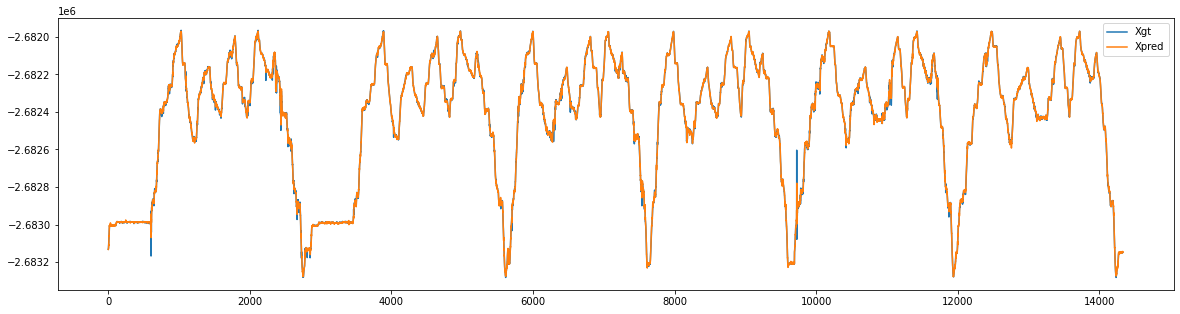

In [50]:
Xoof_df[['Xgt', 'Xpred']].plot(figsize=(20,5))

<AxesSubplot:>

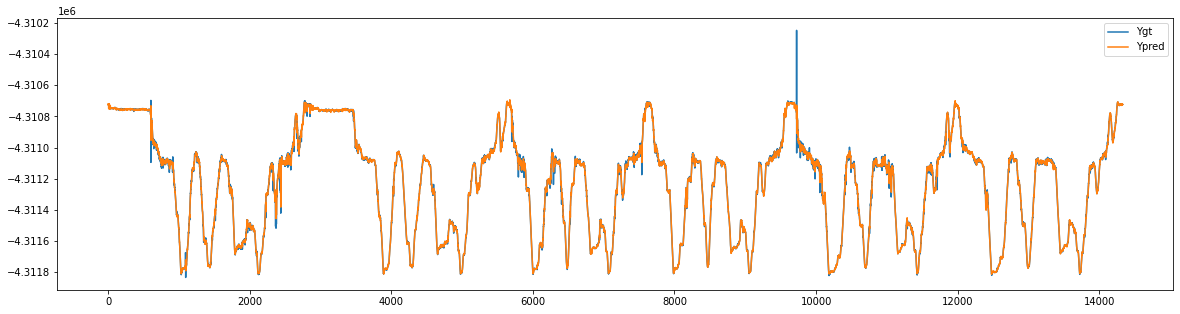

In [51]:
Yoof_df[['Ygt', 'Ypred']].plot(figsize=(20,5))

<AxesSubplot:>

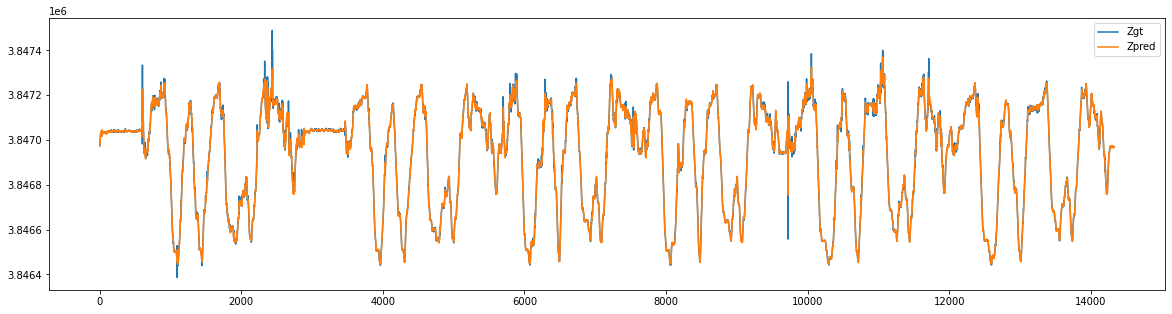

In [52]:
Zoof_df[['Zgt', 'Zpred']].plot(figsize=(20,5))

In [53]:
# for Pseudo Labeling
test["Xgt"] = Xpred
test["Ygt"] = Ypred
test["Zgt"] = Zpred
test.to_csv("test_pl.csv", index=False)

In [ ]:
# xyz -> lng, lat
lng_gt, lat_gt, _ = ECEF_to_WGS84(Xoof_df['Xgt'].values, Yoof_df['Ygt'].values, Zoof_df['Zgt'].values)
lng_pred, lat_pred, _ = ECEF_to_WGS84(Xoof_df['Xpred'].values,Yoof_df['Ypred'].values,Zoof_df['Zpred'].values)
lng_test_pred, lat_test_pred, _ = ECEF_to_WGS84(Xpred, Ypred, Zpred)

In [ ]:
lng_gt.shape, lng_pred.shape, lng_test_pred.shape

In [ ]:
train['target_latDeg'] = lat_gt
train['target_lngDeg'] = lng_gt
train['latDeg'] = lat_pred
train['lngDeg'] = lng_pred
test["latDeg"] = lat_test_pred
test["lngDeg"] = lng_test_pred

In [ ]:
# baseline vs. GT
train_point = train_point.rename(columns={"latDeg_bl":"latDeg", "lngDeg_bl":"lngDeg"})
_, _ = check_score(train_point)

In [ ]:
# IMU Prediction vs. GT
_, _ = check_score(train)

In [ ]:

fig = px.scatter_mapbox(train,                              
                        # Here, plotly gets, (x,y) coordinates
                        lat="latDeg",
                        lon="lngDeg",
                        # text='elapsed_time',
                            
                        #Here, plotly detects color of series
                        color="collectionName",
                        labels="collectionName",
                            
                        zoom=9,
                        center={"lat":37.423576, "lon":-122.094132},
                        height=600,
                        width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# fig.update_layout(title_text="{collection_name}")
fig.show()

In [ ]:
_train_df = train_df.copy()
for (collection_name, phone_name), df in train_city_df.groupby(["collectionName", "phoneName"]):
    query = _train_df[(_train_df['collectionName']==collection_name)&(_train_df["phoneName"]==phone_name)].index[window_size:]
    _train_df.loc[query, "latDeg"] = df["latDeg"].values
    _train_df.loc[query, "lngDeg"] = df["lngDeg"].values

In [ ]:
# targetが変わっている？
# 2回目だと正常な値
train_df, _ = check_score(train_df)  # before
_train_df, _ = check_score(_train_df)  # after

In [ ]:
_test_df = test_df.copy()
for (collection_name, phone_name), df in test_city_df.groupby(["collectionName", "phoneName"]):

    query = _test_df[(_test_df['collectionName']==collection_name)&(_test_df["phoneName"]==phone_name)].index[window_size:]
    if len(query) == len(df):
        _test_df.loc[query, "latDeg"] = df["latDeg"].values
        _test_df.loc[query, "lngDeg"] = df["lngDeg"].values
    else:
        print(collection_name)
        print(phone_name)

In [ ]:
# collection_name = "2021-03-25-US-PAO-1"
# phone_name = "Mi8"

# print(target_test_point_df[(target_test_point_df["collectionName"] == collection_name)&(target_test_point_df["phoneName"]==phone_name)].shape)
# print(_test_df[(_test_df["collectionName"] == collection_name)&(_test_df["phoneName"]==phone_name)].shape)

In [ ]:
# collection_name = "2021-03-25-US-PAO-1"
# phone_name = "SamsungS20Ultra"

# print(target_test_point_df[(target_test_point_df["collectionName"] == collection_name)&(target_test_point_df["phoneName"]==phone_name)].shape)
# print(_test_df[(_test_df["collectionName"] == collection_name)&(_test_df["phoneName"]==phone_name)].shape)

In [ ]:
_train_df.to_csv("delta_train.csv", index=False)
_test_df.to_csv("delta_test.csv", index=False)

In [ ]:
train_df = pd.read_csv("../exp044/delta_train.csv")
test_df = pd.read_csv("../exp044/delta_test.csv")

In [ ]:
# train_df2 = pd.DataFrame()
# for phone, df in _train_df.groupby("phone"):
#     df["elapsed_time"] = (df["millisSinceGpsEpoch"] - df["millisSinceGpsEpoch"].min()) / 1000
#     train_df2 = pd.concat([train_df2, df]).reset_index(drop=True)
# train_df2["elapsed_time"] = train_df2["elapsed_time"].astype(str)

# fig = px.scatter_mapbox(train_df2,                              
#                         # Here, plotly gets, (x,y) coordinates
#                         lat="latDeg",
#                         lon="lngDeg",
#                         text='elapsed_time',
                            
#                         #Here, plotly detects color of series
#                         color="collectionName",
#                         labels="collectionName",
                            
#                         zoom=9,
#                         center={"lat":37.423576, "lon":-122.094132},
#                         height=600,
#                         width=800)
# fig.update_layout(mapbox_style='stamen-terrain')
# fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# # fig.update_layout(title_text="{collection_name}")
# fig.show()

In [ ]:
# test_df2 = pd.DataFrame()
# for phone, df in test_df.groupby("phone"):
#     df["elapsed_time"] = (df["millisSinceGpsEpoch"] - df["millisSinceGpsEpoch"].min()) / 1000
#     test_df2 = pd.concat([test_df2, df]).reset_index(drop=True)
# test_df2["elapsed_time"] = test_df2["elapsed_time"].astype(str)

# fig = px.scatter_mapbox(test_df2,                              
#                         # Here, plotly gets, (x,y) coordinates
#                         lat="latDeg",
#                         lon="lngDeg",
#                         text='elapsed_time',
                            
#                         #Here, plotly detects color of series
#                         color="collectionName",
#                         labels="collectionName",
                            
#                         zoom=9,
#                         center={"lat":37.423576, "lon":-122.094132},
#                         height=600,
#                         width=800)
# fig.update_layout(mapbox_style='stamen-terrain')
# fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# # fig.update_layout(title_text="{collection_name}")
# fig.show()

In [ ]:
train_df, score_df = check_score(train_df)

# train_df = linear_interpolation(train_df)
# train_df, score_df = check_score(train_df)

# train_df = outlier_correction(train_df)
# train_df, score_df = check_score(train_df)

train_df = apply_kf_smoothing(train_df)
train_df, score_df = check_score(train_df)

train_df = apply_mean(train_df)
train_df, score_df = check_score(train_df)

# train_df = get_removedevice(train_df, 'Pixel4')
# train_df, score_df = check_score(train_df)

# train_df = get_removedevice(train_df, 'SamsungS20Ultra')
# train_df, score_df = check_score(train_df)

# train_df = get_removedevice(train_df, 'Pixel4XL')
# train_df, score_df = check_score(train_df)

train_df = add_road_type(train_df, phase="train")

train_df = apply_snap_to_grid(train_df, road_points, min_thr=0, max_thr=100, phase="train")
train_df, score_df = check_score(train_df)

train_df = apply_mean(train_df)
train_df, score_df = check_score(train_df)

train_df = stop_mean(train_df, phase="train")
train_df, score_df = check_score(train_df)

train_df = epoch_mean(train_df)
train_df, score_df = check_score(train_df)

train_df = apply_mean(train_df)
train_df, score_df = check_score(train_df)

In [ ]:
train_df.to_csv("oof.csv", index=False)

In [ ]:
# test_df = linear_interpolation(test_df)
# test_df = outlier_correction(test_df)
test_df = apply_kf_smoothing(test_df, phase="test")
test_df = apply_mean(test_df)
# test_df = get_removedevice(test_df, 'Pixel4')
# test_df = get_removedevice(test_df, 'SamsungS20Ultra')
# test_df = get_removedevice(test_df, 'Pixel4XL')

test_df = add_road_type(test_df, phase="test")
test_df = apply_snap_to_grid(test_df, road_points, min_thr=0, max_thr=100, phase="test")
test_df = stop_mean(test_df, phase="test")
test_df = epoch_mean(test_df)
test_df = apply_mean(test_df)
test_df['phone'] = test_df['collectionName'] + "_" + test_df['phoneName']

In [ ]:
test_df2 = pd.DataFrame()
for phone, df in test_df.groupby("phone"):
    df["elapsed_time"] = (df["millisSinceGpsEpoch"] - df["millisSinceGpsEpoch"].min()) / 1000
    test_df2 = pd.concat([test_df2, df]).reset_index(drop=True)
test_df2["elapsed_time"] = test_df2["elapsed_time"].astype(str)

fig = px.scatter_mapbox(test_df2,                              
                        # Here, plotly gets, (x,y) coordinates
                        lat="latDeg",
                        lon="lngDeg",
                        text='elapsed_time',
                            
                        #Here, plotly detects color of series
                        color="collectionName",
                        labels="collectionName",
                            
                        zoom=9,
                        center={"lat":37.423576, "lon":-122.094132},
                        height=600,
                        width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# fig.update_layout(title_text="{collection_name}")
fig.show()

In [ ]:
sub_df = sub_df.drop(['latDeg', 'lngDeg'], axis=1).merge(test_df[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['phone', 'millisSinceGpsEpoch'])
sub_df.to_csv(f'{EXP_NAME}_submission.csv', index=False)

In [ ]:
_sub_df = pd.read_csv(f'../exp044/exp044_submission.csv')

In [ ]:
calc_haversine(sub_df['latDeg'],sub_df['lngDeg'],_sub_df['latDeg'], _sub_df['lngDeg']).mean()